# Data Analytics Final Project
## Used Car Price Analysis in Germany
Ci Chen, Fu-Chi Shih, Naixin Li

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
import seaborn as sns
sns.set_style("white")

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## Clean and Prepare Data

### Import the original data

In [5]:
autos = pd.read_csv("autos.csv",encoding='ISO-8859-1')

In [6]:
autos.shape

(371528, 20)

In [7]:
autos.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [8]:
autos.head(3)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


### Select relevant features

The original data set contains 20 features. Our goal is to use relevant features to predict the price of used cars. Some features are unrelevant, such as dateCrawled (the date that the ad is crawled). Thus, we first delete these features.

In [9]:
selected = autos[['price', 'vehicleType','yearOfRegistration', 'gearbox', 'powerPS', 'kilometer', 'fuelType', 'brand',
'notRepairedDamage', 'nrOfPictures']]

In [10]:
selected.shape

(371528, 10)

### Drop NAs
Delete observations that have NAs in any feature.

In [11]:
clean = selected.dropna()

In [12]:
clean.shape

(268012, 10)

In [13]:
clean.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage,nrOfPictures
1,18300,coupe,2011,manuell,190,125000,diesel,audi,ja,0
3,1500,kleinwagen,2001,manuell,75,150000,benzin,volkswagen,nein,0
4,3600,kleinwagen,2008,manuell,69,90000,diesel,skoda,nein,0
5,650,limousine,1995,manuell,102,150000,benzin,bmw,ja,0
6,2200,cabrio,2004,manuell,109,150000,benzin,peugeot,nein,0


### Create a new feature called Age
We think the age of a used car might be a good predictor of the price. Therefore, we create a new feature called age = 2016 - year of Registration.

In [14]:
clean["age"]= (2016 - clean.yearOfRegistration)

/Users/farahshih/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
clean.dtypes # check data types

price                  int64
vehicleType           object
yearOfRegistration     int64
gearbox               object
powerPS                int64
kilometer              int64
fuelType              object
brand                 object
notRepairedDamage     object
nrOfPictures           int64
age                    int64
dtype: object

### Explore Data and delete unreasonable observations

In [16]:
clean.describe() 

,price,yearOfRegistration,powerPS,kilometer,nrOfPictures,age
count,2.680120e+05,268012.000000,268012.000000,268012.000000,268012.0,268012.000000
mean,1.670892e+04,2003.183384,126.634039,123957.845171,0.0,12.816616
std,4.166542e+06,6.710427,155.758016,40018.897080,0.0,6.710427
min,0.000000e+00,1910.000000,0.000000,5000.000000,0.0,-2.000000
25%,1.500000e+03,1999.000000,77.000000,100000.000000,0.0,8.000000
50%,3.800000e+03,2004.000000,116.000000,150000.000000,0.0,12.000000
75%,8.600000e+03,2008.000000,150.000000,150000.000000,0.0,17.000000
max,2.147484e+09,2018.000000,20000.000000,150000.000000,0.0,106.000000


In [17]:
## The feature "nrOfPictures"(number of pictures) has value "0" only. Thus, we delete this feature. 
## "yearOfRegistration" is already reflected in "age". 
clean = clean.drop(["nrOfPictures","yearOfRegistration"],1) 

From the above statistics, we can detect unreasonable observations. Before building model, we need to exclude these data.

In [18]:
## Few observations have negative age: there might be typos in the original data. Thus, we delete these observations as well. 
clean = clean.query('age >= 0')

In [19]:
## Few observations have extreme "powerPS" (horse power) values. 
## (The usual horse power level for most cars are below 500). Thus, we exclude observations that have PowerPS over 500.
clean = clean.query('powerPS < 500 & powerPS>0')

In [20]:
## Few observations have extreme selling price (>50,000 or <100). 
## Since we want to focus on the mass market, we exclude these outliers from our data set.
clean = clean.query('price < 0.05e6 & price >100')

In [21]:
clean.shape

(251624, 9)

### Selete data based on vehicle Types

In [22]:
clean.vehicleType.value_counts() 

limousine     74106
kleinwagen    56027
kombi         51597
bus           24216
cabrio        18132
coupe         13974
suv           11929
andere         1643
Name: vehicleType, dtype: int64

In [23]:
## Our market is to focus on prive-owned cars. Thus, we select observations with vehicleType = limousine or kleinwagen.
final_df = clean.query('(vehicleType =="limousine" | vehicleType =="kleinwagen")')

In [24]:
## Some fuel type have too few observations. We are not focusing one these markets neither.
final_df.fuelType.value_counts() ## Translation:"benzin" means petrol; "andere" means others ; "elektro" means electric

benzin     100060
diesel      28059
lpg          1681
hybrid        159
cng            95
elektro        45
andere         34
Name: fuelType, dtype: int64

In [25]:
final_df = final_df.query('fuelType == "benzin" | fuelType == "diesel" | fuelType == "lpg"')

In [26]:
## Some brands that have too few sample size. And the market size for these brands are really small. Thus, we 
## decided not to focuse on these brands. 
brand_count = final_df.brand.value_counts()
brand_count[brand_count > 500].index

Index(['volkswagen', 'bmw', 'opel', 'mercedes_benz', 'audi', 'ford', 'renault',
       'fiat', 'peugeot', 'seat', 'smart', 'nissan', 'toyota', 'mini',
       'citroen', 'skoda', 'mazda', 'hyundai', 'honda', 'mitsubishi',
       'alfa_romeo', 'suzuki', 'kia', 'chevrolet', 'volvo'],
      dtype='object')

In [27]:
final_df = final_df[final_df.brand.isin(brand_count[brand_count > 500].index)] 

In [28]:
final_df.brand.value_counts()

volkswagen       28786
bmw              15412
opel             13991
mercedes_benz    11283
audi             10466
ford              8275
renault           6151
fiat              4392
peugeot           3906
seat              3838
smart             2204
nissan            1998
toyota            1944
mini              1840
citroen           1745
skoda             1644
mazda             1583
hyundai           1382
honda             1158
mitsubishi        1076
alfa_romeo         910
suzuki             897
kia                833
chevrolet          619
volvo              536
Name: brand, dtype: int64

In [29]:
final_df.gearbox.value_counts()

manuell      103183
automatik     23686
Name: gearbox, dtype: int64

In [30]:
final_df.notRepairedDamage.value_counts()

nein    113716
ja       13153
Name: notRepairedDamage, dtype: int64

In [31]:
final_df.shape

(126869, 9)

In [32]:
final_df.head(5)

,price,vehicleType,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage,age
3,1500,kleinwagen,manuell,75,150000,benzin,volkswagen,nein,15
4,3600,kleinwagen,manuell,69,90000,diesel,skoda,nein,8
5,650,limousine,manuell,102,150000,benzin,bmw,ja,21
10,2000,limousine,manuell,105,150000,benzin,mazda,nein,12
17,1750,kleinwagen,automatik,75,150000,benzin,renault,nein,12


In [33]:
final_df.describe(include=["O"])

,vehicleType,gearbox,fuelType,brand,notRepairedDamage
count,126869,126869,126869,126869,126869
unique,2,2,3,25,2
top,limousine,manuell,benzin,volkswagen,nein
freq,72198,103183,97565,28786,113716


In [34]:
final_df.describe() 

,price,powerPS,kilometer,age
count,126869.000000,126869.000000,126869.000000,126869.000000
mean,5057.095626,111.121346,122135.273392,13.045078
std,5832.917545,56.212869,40244.047777,6.286309
min,101.000000,1.000000,5000.000000,0.000000
25%,1299.000000,71.000000,100000.000000,8.000000
50%,2900.000000,101.000000,150000.000000,13.000000
75%,6690.000000,140.000000,150000.000000,17.000000
max,49999.000000,490.000000,150000.000000,80.000000


## Build Model and Evaluate Model

### Split data into training, validation, and test datasets

In [35]:
## create random number 
n=final_df.shape[0]
numpy.random.seed(1234)
shuffle = numpy.arange(n)
print('Before:')
print(shuffle)
numpy.random.shuffle(shuffle)
print('After:')
print(shuffle)

Before:
[     0      1      2 ..., 126866 126867 126868]
After:
[60416 62590  1023 ..., 34086 58067 92975]


In [36]:
## We split the data into training data (80%), validation data (10%), and test data(10%)
cut1=int(round(n*0.8))
cut2=cut1+int(round(n*0.1))
train_indices = shuffle[0:cut1]
validation_indices = shuffle[cut1:cut2]
test_indices = shuffle[cut2:]
print("Train#") ; print(len(train_indices))
print("Validation#") ; print(len(validation_indices))
print("Test#") ; print(len(test_indices))
n == (len(train_indices)+len(validation_indices)+len(test_indices)) ## check if data split is correct

Train#
101495
Validation#
12687
Test#
12687


True

In [37]:
print(train_indices)

[ 60416  62590   1023 ..., 113518  24951  34934]


In [38]:
train = final_df.iloc[train_indices,]
validation=final_df.iloc[validation_indices,]
test = final_df.iloc[test_indices,]
print(train.shape)
print(validation.shape)
print(test.shape)

(101495, 9)
(12687, 9)
(12687, 9)


### Check correlations

In [39]:
train.corr() 

,price,powerPS,kilometer,age
price,1.000000,0.579053,-0.469563,-0.581910
powerPS,0.579053,1.000000,0.033730,-0.193433
kilometer,-0.469563,0.033730,1.000000,0.472399
age,-0.581910,-0.193433,0.472399,1.000000


### Build Model

In [40]:
linear_model_formula ="price ~ C(vehicleType) + C(gearbox)+ powerPS + C(brand) + C(fuelType) + C(notRepairedDamage) + age + kilometer"
linear_model = smf.ols(formula=linear_model_formula, data=train)
print(type(linear_model))

linear_model_fit = linear_model.fit()
print(type(linear_model_fit))

<class 'statsmodels.regression.linear_model.OLS'>
<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>


In [41]:
linear_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     7337.
Date:                Sat, 14 Jan 2017   Prob (F-statistic):               0.00
Time:                        23:41:06   Log-Likelihood:            -9.6285e+05
No. Observations:              101495   AIC:                         1.926e+06
Df Residuals:                  101462   BIC:                         1.926e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                     7691.1845    138.105     55.691      0.000      7420.500  7961.869
C(vehicleType)[T.limousine]   -163.6415     27.417     -5.969      0.000      -217.378  -109.905
C(gearbox)[T.manuell]         -889.7086     31.332    -28.396      0.000      -951.119  -828.298
C(brand)[T.audi]              3138.7249    124.043     25.304      0.000      2895.602  3381.848
C(brand)[T.bmw]               2687.8781    122.639     21.917      0.000      2447.507  2928.249
C(brand)[T.chevrolet]         -950.9002    187.415     -5.074      0.000     -1318.232  -583.569
C(brand)[T.citroen]            842.7063    147.101      5.729      0.000       554.389  1131.023
C(brand)[T.fiat]              1031.0137    131.651      7.831      0.000       772.979  1289.048
C(brand)[T.ford]               939.3870    125.764      7.469      0.000       692.891  1185.883
C(brand)[T.honda]             1599.5255    158.680     10.080      0.000      1288.514  1910.537
C(brand)[T.hyundai]           -188.3102    153.537     -1.226      0.220      -489.241   112.620
C(brand)[T.kia]                107.3039    171.595      0.625      0.532      -229.019   443.627
C(brand)[T.mazda]              919.7889    149.508      6.152      0.000       626.755  1212.823
C(brand)[T.mercedes_benz]     2331.2363    124.311     18.753      0.000      2087.588  2574.885
C(brand)[T.mini]              3213.5175    146.658     21.912      0.000      2926.071  3500.965
C(brand)[T.mitsubishi]         871.8095    161.445      5.400      0.000       555.380  1188.239
C(brand)[T.nissan]            1589.3875    143.709     11.060      0.000      1307.721  1871.054
C(brand)[T.opel]              1467.0998    123.201     11.908      0.000      1225.627  1708.572
C(brand)[T.peugeot]            839.7699    132.628      6.332      0.000       579.821  1099.719
C(brand)[T.renault]           1089.5544    128.290      8.493      0.000       838.107  1341.002
C(brand)[T.seat]              1433.5488    132.737     10.800      0.000      1173.387  1693.711
C(brand)[T.skoda]             1047.2151    148.613      7.047      0.000       755.936  1338.494
C(brand)[T.smart]             -120.5080    145.517     -0.828      0.408      -405.719   164.704
C(brand)[T.suzuki]             523.0790    169.579      3.085      0.002       190.707   855.451
C(brand)[T.toyota]             920.9734    143.933      6.399      0.000       638.867  1203.079
C(brand)[T.volkswagen]        2557.2414    121.017     21.131      0.000      2320.051  2794.432
C(brand)[T.volvo]             1723.8983    193.160      8.925      0.000      1345.307  2102.490
C(fuelType)[T.diesel]         1904.5421     27.654     68.871      0.000      1850.341  1958.743
C(fuelType)[T.lpg]            -926.0823     91.453    -10.126      0.000    

### Evaluate the model

In [42]:
## use our fitted model to predict the price for validation data set and compute the RMS error
y_train = train.price
y_val = validation.price
y_test = test.price

predicted_y_train = linear_model_fit.predict(train)
predicted_y_val = linear_model_fit.predict(validation)

print("done")
rms_error = numpy.sqrt(numpy.mean((y_train - predicted_y_train) ** 2))
print('RMS train error: ' + str(rms_error))

rms_error = numpy.sqrt(numpy.mean((y_val - predicted_y_val) ** 2))
print('RMS validation error: ' + str(rms_error))

done
RMS train error: 3190.01952701
RMS validation error: 3335.22116281


In [43]:
## compute the correlation between the actual price and predicted price
np.corrcoef(y_val, predicted_y_val)

array([[ 1.      ,  0.828003],
       [ 0.828003,  1.      ]])

## Visualize the relationship between siginificant factors and price

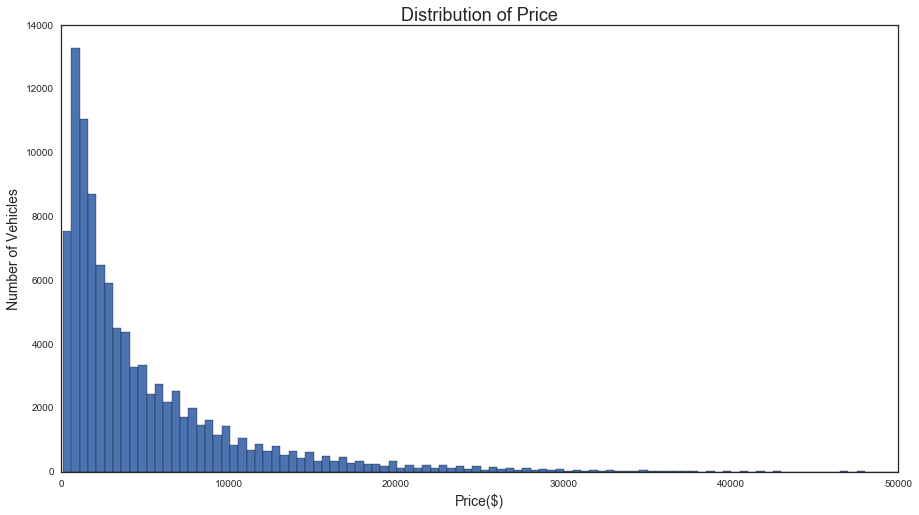

In [44]:
plt.hist(train["price"], bins=100)
plt.xlabel("Price($)",fontsize=14)
plt.ylabel("Number of Vehicles",fontsize=14)
plt.title("Distribution of Price",fontsize=18)
plt.show()

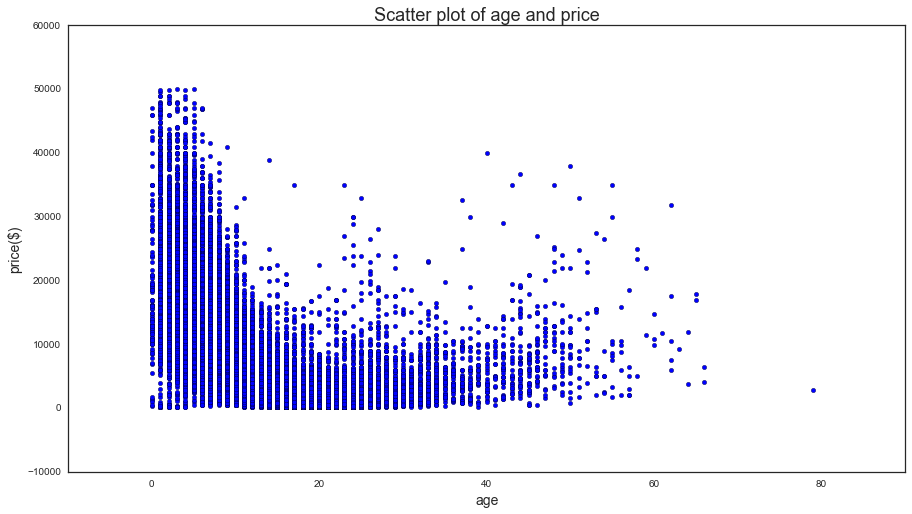

In [45]:
plt.scatter(train["age"], train["price"])
plt.xlabel("age", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Scatter plot of age and price",fontsize=18)
plt.show()

In [46]:
train["age_bin"]=pd.cut(train["age"], 10)

/Users/farahshih/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


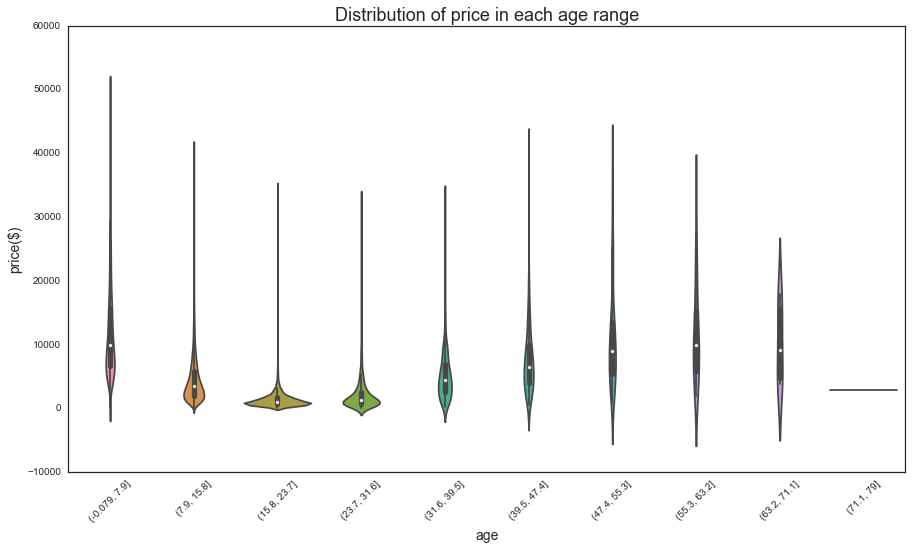

In [47]:
sns.violinplot(x="age_bin", y="price", data=train)
plt.xticks(rotation=45)
plt.xlabel("age", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price in each age range", fontsize=18)
plt.show()

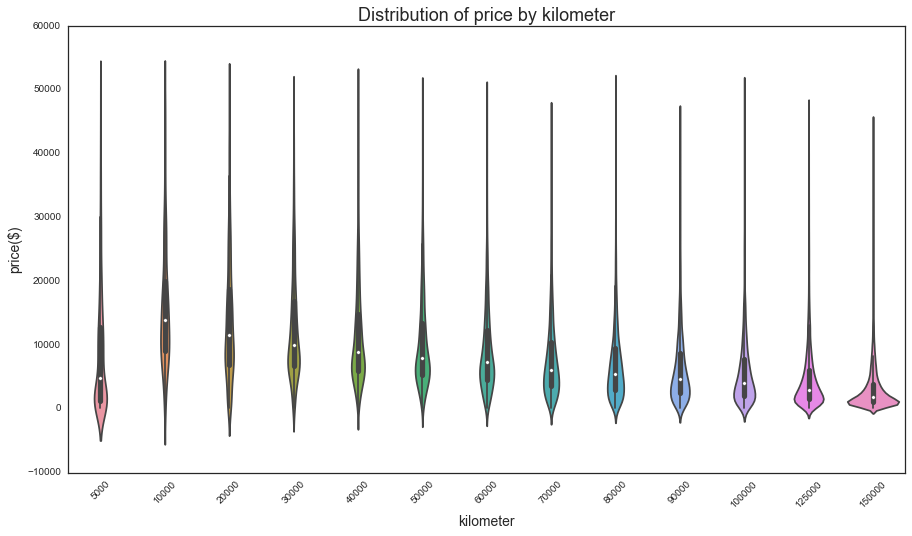

In [48]:
sns.violinplot(x="kilometer", y="price", data=train)
plt.xticks(rotation=45)
plt.xlabel("kilometer", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price by kilometer", fontsize=18)
plt.show()

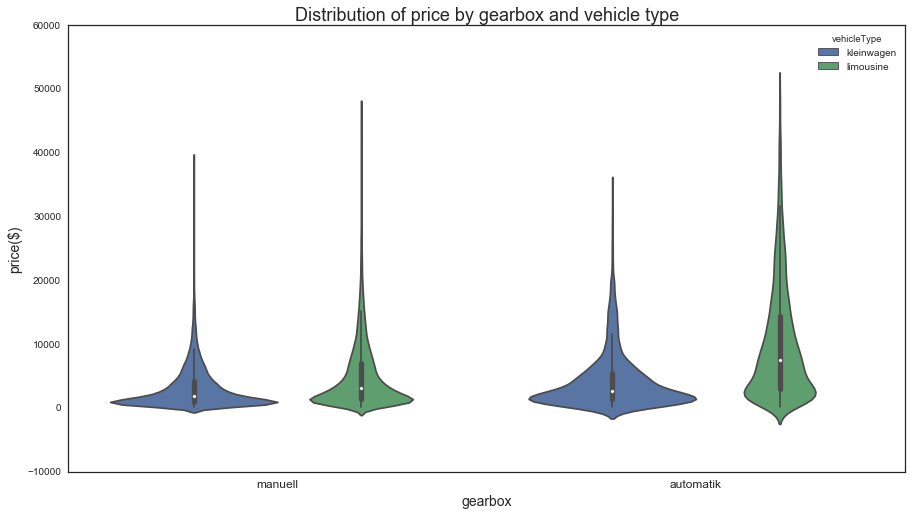

In [49]:
sns.violinplot(x="gearbox", y="price", data=train, hue="vehicleType")
plt.xticks(fontsize=12)
plt.xlabel("gearbox", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price by gearbox and vehicle type", fontsize=18)
plt.show()

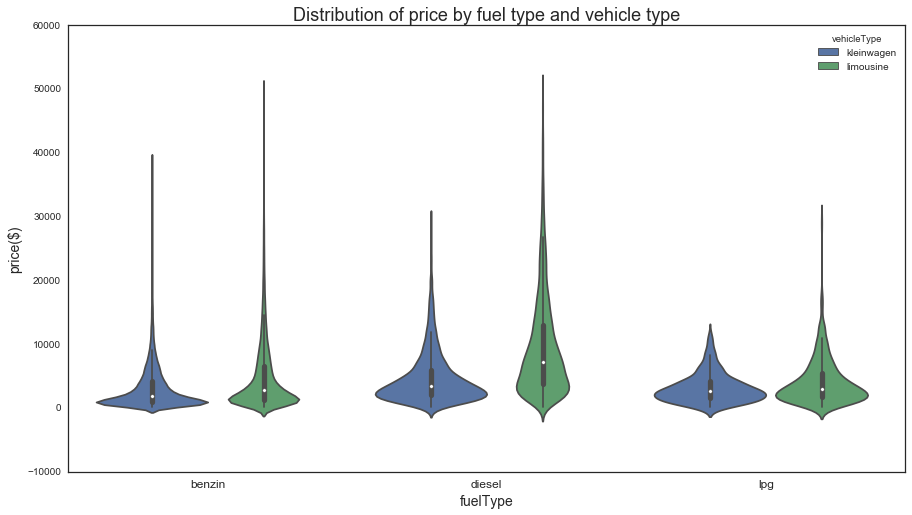

In [50]:
sns.violinplot(x="fuelType", y="price", data=train,hue="vehicleType")
plt.xticks(fontsize=12)
plt.xlabel("fuelType", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price by fuel type and vehicle type", fontsize=18)
plt.show()

In [51]:
train["power_bin"]=pd.cut(train["powerPS"], 6)

/Users/farahshih/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


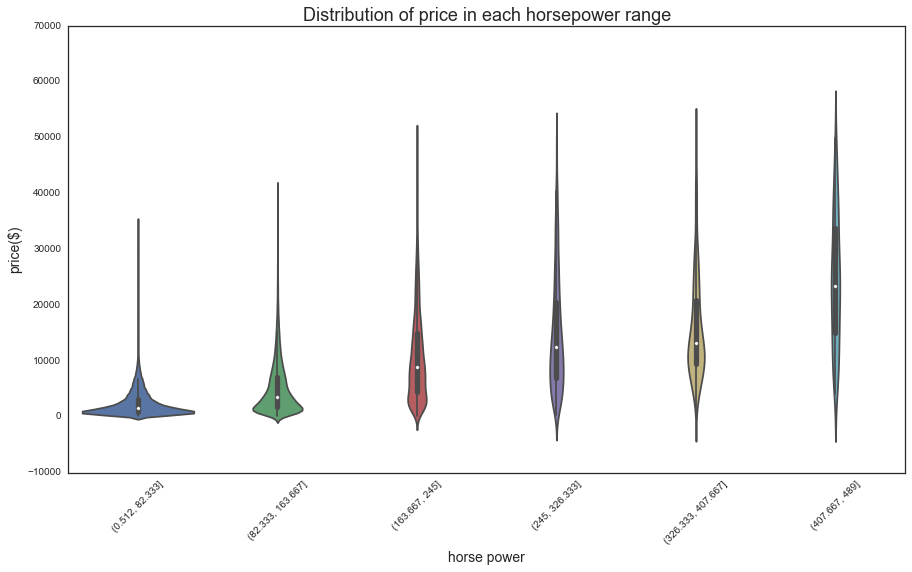

In [52]:
sns.violinplot(x="power_bin", y="price", data=train)
plt.xticks(rotation=45)
plt.xlabel("horse power", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price in each horsepower range", fontsize=18)
plt.show()

In [53]:
train.columns

Index(['price', 'vehicleType', 'gearbox', 'powerPS', 'kilometer', 'fuelType',
       'brand', 'notRepairedDamage', 'age', 'age_bin', 'power_bin'],
      dtype='object')

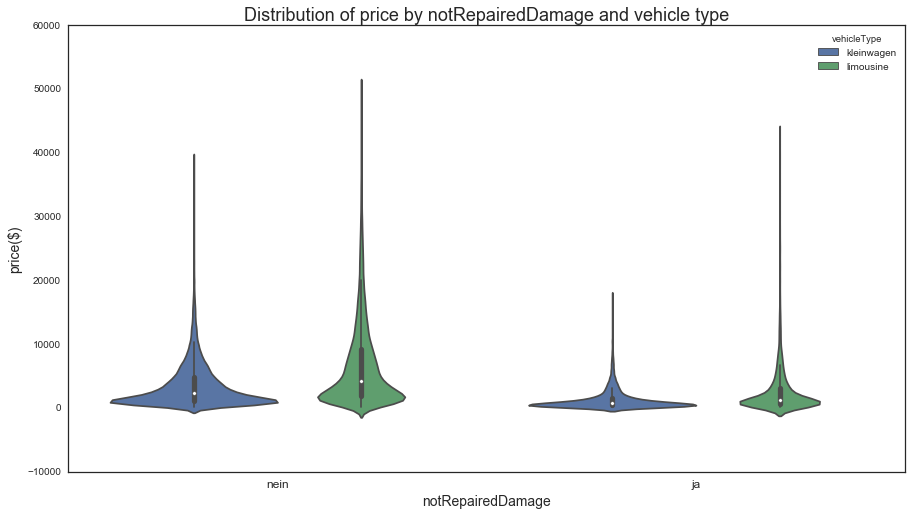

In [54]:
sns.violinplot(x="notRepairedDamage", y="price", data=train, hue="vehicleType")
plt.xticks(fontsize=12)
plt.xlabel("notRepairedDamage", fontsize=14)
plt.ylabel("price($)", fontsize=14)
plt.title("Distribution of price by notRepairedDamage and vehicle type", fontsize=18)
plt.show()

## Model Assessment
Assess how our model perform on test data set.

In [55]:
## compute the RMS error
predicted_y_test = linear_model_fit.predict(test)
rms_error = numpy.sqrt(numpy.mean((y_test - predicted_y_test) ** 2))
print('RMS test error: ' + str(rms_error))
print('ok')

RMS test error: 3240.2865587
ok


In [56]:
## compute the correlation between predicted value for test data and actual value.
np.corrcoef(y_test, predicted_y_test)

array([[ 1.        ,  0.83700193],
       [ 0.83700193,  1.        ]])